In [1]:
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Variables globales
rect = (0, 0, 1, 1)
drawing = False
rectangle = False
show_temp_rect = False


# Callback de la souris
def draw_rectangle(event, x, y, flags, param):
    global rect, drawing, rectangle, show_temp_rect

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        rect = (x, y, 1, 1)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        rectangle = True
        rect = (rect[0], rect[1], x - rect[0], y - rect[1])

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            show_temp_rect = True
            rect = (rect[0], rect[1], x - rect[0], y - rect[1])

# Fonction pour créer le graphe à partir de l'image et du rectangle
def image_to_graph(image, rect):
    height, width = image.shape[:2]
    graph = nx.DiGraph()

    graph.add_node('source')
    graph.add_node('sink')

    for i in range(height):
        for j in range(width):
            node = i * width + j
            pixel_value = np.mean(image[i, j])

            if i < height - 1:
                neighbor_node = ((i + 1) * width) + j
                neighbor_value = np.mean(image[i + 1, j])
                weight = abs(pixel_value - neighbor_value)
                graph.add_edge(node, neighbor_node, capacity=weight)

            if j < width - 1:
                neighbor_node = (i * width) + (j + 1)
                neighbor_value = np.mean(image[i, j + 1])
                weight = abs(pixel_value - neighbor_value)
                graph.add_edge(node, neighbor_node, capacity=weight)

            if rect[0] <= j <= rect[0] + rect[2] and rect[1] <= i <= rect[1] + rect[3]:
                graph.add_edge('source', node, capacity=float('inf'))
            else:
                graph.add_edge(node, 'sink', capacity=float('inf'))

    return graph

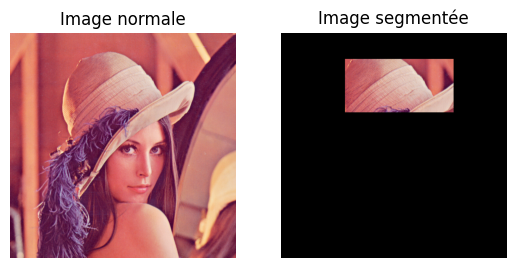

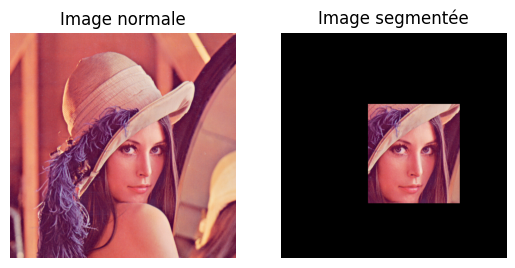

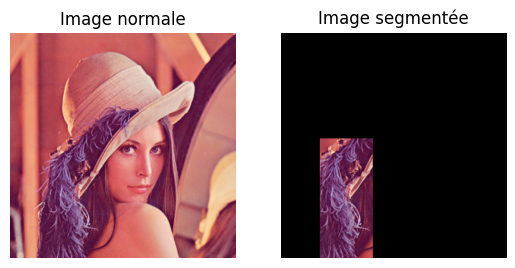

In [3]:
# Chargement de l'image
image = cv2.imread('images/images/lenna.png')
cv2.namedWindow('Image normale')
cv2.setMouseCallback('Image normale', draw_rectangle)
while True:
    temp_image = image.copy()

    if show_temp_rect:
        cv2.rectangle(temp_image, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 2)

    cv2.imshow('Image normale', temp_image)

    k = cv2.waitKey(1)

    # k = 32 Appuyez sur 'Espace' pour effectuer la segmentation

    if rectangle and k == 32:
        graph = image_to_graph(image, rect)

        cut_value, partition = nx.minimum_cut(graph, 'source', 'sink')
        reachable, _ = partition

        partition_array = np.array([1 if node in reachable else 0 for node in graph.nodes if node != 'source'])
        partition_array = partition_array[:-1]
        mask = partition_array.reshape(image.shape[:2]) * 255
        result = cv2.bitwise_and(image, image, mask=mask.astype(np.uint8))
        plt.subplot(1,2,1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Image normale')
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title('Image segmentée')
        plt.axis('off')
        plt.show()
        show_temp_rect = False
        

    if k == 27:  # Appuyez sur 'Esc' pour quitter
        break

   
cv2.destroyAllWindows()

